Microbleed Feature Extraction

In [ ]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import radon
import matplotlib.pyplot as plt

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois

# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa


def compute_radon_features(microbleed_rois, angles):
    sinograms = []
    for roi_slice in microbleed_rois:
        rotated_slices = [scipy.ndimage.rotate(roi_slice, angle, reshape=False) for angle in angles]
        sinogram = np.stack(rotated_slices, axis=-1)
        sinograms.append(sinogram)
    return np.stack(sinograms, axis=0)

def compute_radon_shape_features(radon_features):
    # Extract the dimensions
    num_coordinates, roi_size_x, roi_size_y, roi_size_z, num_angles = radon_features.shape
    
    # Initialize arrays to store results
    fmean = np.zeros((num_coordinates, num_angles))
    fstd = np.zeros((num_coordinates, num_angles))
    
    # Compute Radon shape features
    for coord in range(num_coordinates):
        for angle in range(num_angles):
            # Mean profile
            fmean[coord, angle] = np.mean(radon_features[coord, :, :, :, angle])
            
            # Standard deviation profile
            fstd[coord, angle] = np.std(radon_features[coord, :, :, :, angle])

            
    return fmean, fstd

# Load the Excel file containing microbleed coordinates
excel_file = 'coordinate_yes.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'rCMB_only'  # Replace 'path_to_rCMB_folder' with your folder path
combined_features_list = []
# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        microbleed_coordinates = []
        for i in range(1, len(row), 3):
                try:
                    if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                        x = int(row.iloc[i])
                        y = int(row.iloc[i+1])
                        z = int(row.iloc[i+2])
                        microbleed_coordinates.append((x, y, z))
                except (ValueError, TypeError):
                    pass
            # Define the size of the ROI around each microbleed
        roi_size = 10 # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Radon features for each ROI
        angles = np.arange(0, 180, 15)
        radon_features_microbleed = compute_radon_features(microbleed_rois, angles)

        # Compute Radon shape features for each microbleed
        fmean_microbleed_radon, fstd_microbleed_radon = compute_radon_shape_features(radon_features_microbleed)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue

            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append(np.array([f_sphere, f_lc, f_fa]))

        # Append Radon features (flattened) with Hessian features 
        for coord, fmean_values, fstd_values, hessian_features in zip(
                microbleed_coordinates, fmean_microbleed_radon, fstd_microbleed_radon, hessian_shape_features_microbleed
        ):
            flattened_radon_values = np.concatenate((fmean_values.flatten(), fstd_values.flatten()))
            combined_features = np.concatenate((np.array(flattened_radon_values), np.array(hessian_features)))
            #print(hessian_features)
            #print(flattened_radon_values)
            #print(combined_features)
            X.append(combined_features)
            #print(X)
            #print()
# Convert the list of microbleed features to a NumPy array
X1 =  np.array(X)
print(X1.shape)
print(X1)

Storing Microbleed features and it's corresponding label

In [2]:
# Determine the number of microbleeds in X
num_microbleeds = X1.shape[0]

# Set the labels for microbleeds as 1
Y1 = np.ones(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y1.shape}")

# Display a few labels to confirm
print(Y1)

Shape of Y0 (labels): (146,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


Non-Microbleed Feature Extraction

In [3]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import radon
import matplotlib.pyplot as plt

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois


# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa



def compute_radon_features(microbleed_rois, angles):
    sinograms = []
    for roi_slice in microbleed_rois:
        rotated_slices = [scipy.ndimage.rotate(roi_slice, angle, reshape=False) for angle in angles]
        sinogram = np.stack(rotated_slices, axis=-1)
        
        # Check if the current sinogram has the same shape as the previous sinograms
        if sinograms and sinogram.shape != sinograms[0].shape:
            #print("Skipping ROI due to different shape:", sinogram.shape)
            continue
        
        sinograms.append(sinogram)
        
    return np.stack(sinograms, axis=0)


def compute_radon_shape_features(radon_features):
    # Extract the dimensions
    num_coordinates, roi_size_x, roi_size_y, roi_size_z, num_angles = radon_features.shape
    
    # Initialize arrays to store results
    fmean = np.zeros((num_coordinates, num_angles))
    fstd = np.zeros((num_coordinates, num_angles))
    
    # Compute Radon shape features
    for coord in range(num_coordinates):
        for angle in range(num_angles):
            # Mean profile
            fmean[coord, angle] = np.mean(radon_features[coord, :, :, :, angle])
            
            # Standard deviation profile
            fstd[coord, angle] = np.std(radon_features[coord, :, :, :, angle])

            #print(fmean)
            #print(fstd)

            
    return fmean, fstd

# Load the Excel file containing microbleed coordinates
excel_file = 'coordinate_non2.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'rCMB_only'  # Replace 'path_to_rCMB_folder' with your folder path
combined_features_list = []
# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        microbleed_coordinates = []
        for i in range(1, len(row), 3):
                try:
                    if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                        x = int(row.iloc[i])
                        y = int(row.iloc[i+1])
                        z = int(row.iloc[i+2])
                        microbleed_coordinates.append((x, y, z))
                except (ValueError, TypeError):
                    pass
            # Define the size of the ROI around each microbleed
        roi_size = 10  # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Radon features for each ROI
        angles = np.arange(0, 180, 15)
        radon_features_microbleed = compute_radon_features(microbleed_rois, angles)

        # Compute Radon shape features for each microbleed
        fmean_microbleed_radon, fstd_microbleed_radon = compute_radon_shape_features(radon_features_microbleed)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue

            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append(np.array([f_sphere, f_lc, f_fa]))

        # Append Radon features (flattened) with Hessian features 
        for coord, fmean_values, fstd_values, hessian_features in zip(
                microbleed_coordinates, fmean_microbleed_radon, fstd_microbleed_radon, hessian_shape_features_microbleed
):
            flattened_radon_values = np.concatenate((fmean_values.flatten(), fstd_values.flatten()))
            combined_features = np.concatenate((np.array(flattened_radon_values), np.array(hessian_features)))
            #print(hessian_features)
            #print(flattened_radon_values)
            #print(combined_features)
            X.append(combined_features)
            #print(X)
# Convert the list of microbleed features to a NumPy array
X0 =  np.array(X)
print(X0.shape)

(155, 27)


Storing Non-Microbleed Features and their corresponding label 

In [4]:
# Determine the number of microbleeds in X
non_microbleeds = X0.shape[0]

# Set the labels for microbleeds as 1
Y0 = np.zeros(non_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y0.shape}")

# Display a few labels to confirm
print(Y0) 

Shape of Y0 (labels): (155,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
X = np.vstack((X1,X0))
print(X.shape)
print(X)
# Create corresponding labels 'y' (1 for microbleeds, 0 for non-microbleeds)
Y = np.hstack((Y1,Y0))
print(Y.shape)
print(Y)

(301, 27)
[[0.09640651 0.07955906 0.07585871 ... 1.45646235 0.17222118 1.21742321]
 [0.15101061 0.12156971 0.11546291 ... 5.73093546 0.0312946  1.22471414]
 [0.12204435 0.09817558 0.0932273  ... 1.56843042 0.23109815 1.19575268]
 ...
 [0.49062042 0.39372586 0.37434993 ... 5.98630646 0.31826743 0.91725632]
 [0.44734212 0.35973623 0.34151699 ... 1.90944206 3.0671348  1.21979153]
 [0.50998079 0.41671642 0.3968642  ... 4.59759012 3.29022687 0.89761945]]
(301,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Random_Forest_Model Creation

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import os

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict labels for the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Calculate Sensitivity
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Calculate False Positive Rate (FPR)
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FPR = TN / (TN + FP)
print("Specificity:", FPR)


# Save the model
with open('rf_classifier_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

Accuracy: 0.9016393442622951
Confusion Matrix:
[[25  5]
 [ 1 30]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89        30
         1.0       0.86      0.97      0.91        31

    accuracy                           0.90        61
   macro avg       0.91      0.90      0.90        61
weighted avg       0.91      0.90      0.90        61

Sensitivity: 0.967741935483871
Specificity: 0.8333333333333334


Determine the Feature_importance for Random forest model 

Feature ranking:
1. feature 1 (0.076569)
2. feature 0 (0.074289)
3. feature 23 (0.067788)
4. feature 21 (0.066375)
5. feature 9 (0.056736)
6. feature 16 (0.051365)
7. feature 7 (0.047930)
8. feature 20 (0.046361)
9. feature 15 (0.043294)
10. feature 5 (0.041396)
11. feature 2 (0.040843)
12. feature 10 (0.040829)
13. feature 8 (0.038411)
14. feature 19 (0.036859)
15. feature 17 (0.036369)
16. feature 13 (0.033766)
17. feature 4 (0.032964)
18. feature 14 (0.031486)
19. feature 22 (0.030652)
20. feature 6 (0.025366)
21. feature 3 (0.022454)
22. feature 11 (0.022304)
23. feature 25 (0.011464)
24. feature 12 (0.008263)
25. feature 26 (0.006306)
26. feature 24 (0.005019)
27. feature 18 (0.004544)


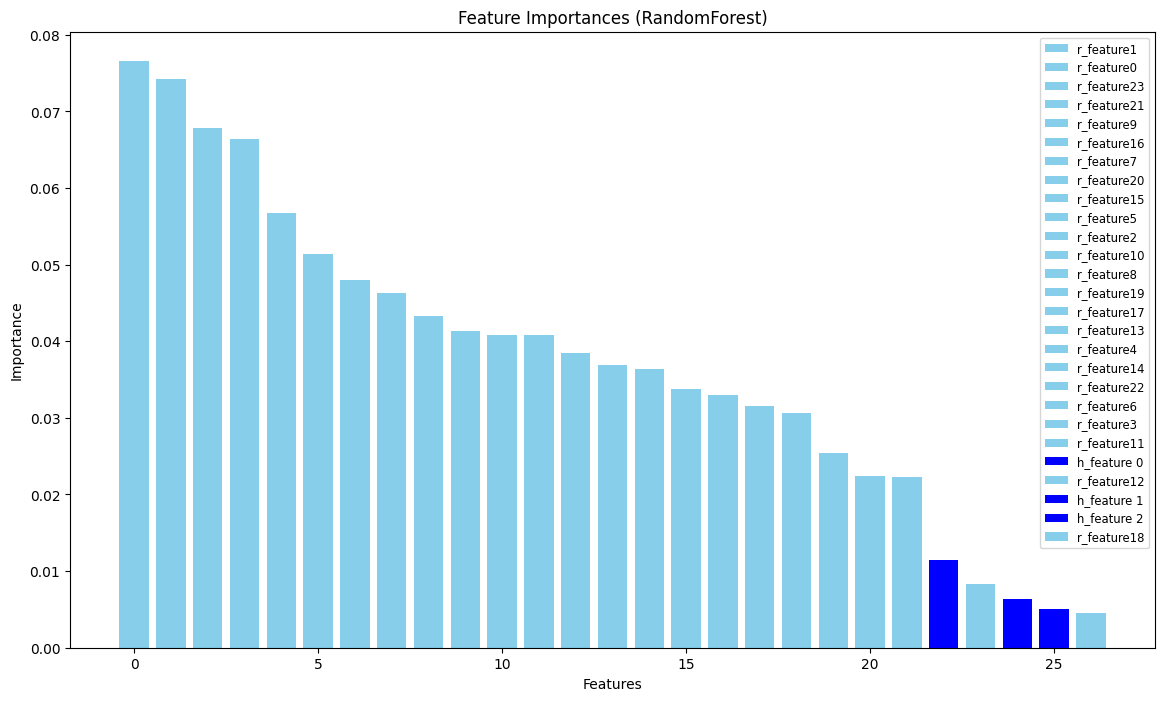

In [9]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train the RandomForest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

# Retrieve feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Define custom feature names for selected features
custom_feature_names = {
    25: 'h_feature 0',
    26: 'h_feature 1',
    24: 'h_feature 2'
}

# Plot the feature importances 
plt.figure(figsize=(14, 8))  # Set the figure size to be larger
plt.title("Feature Importances (RandomForest)")

# Plot top 3 features with custom names, others with numerical indices
for i in range(X_train.shape[1]):
    color = "blue" if custom_feature_names.get(indices[i], None) else "skyblue"  # Set color based on feature name
    label = custom_feature_names.get(indices[i], f'r_feature{indices[i]}')
    plt.bar(i, importances[indices[i]], color=color, align="center", label=label)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.legend(fontsize='small')  # Set legend size to small
plt.show()

XG-Boost model Creation

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import numpy as np
import pickle

# Assuming you have X and Y defined
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the XGBoost classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

# Predict labels for the testing set
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Calculate Sensitivity
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Calculate False Positive Rate (FPR)
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FPR = TN/ (TN + FP)
print("Specificity:", FPR)

# Save the model
with open('xgb_classifier_model.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)

Accuracy: 0.8852459016393442
Confusion Matrix:
[[26  4]
 [ 3 28]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88        30
         1.0       0.88      0.90      0.89        31

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.89        61
weighted avg       0.89      0.89      0.89        61

Sensitivity: 0.9032258064516129
Specificity: 0.8666666666666667


Feature_importance for XG boost model 

Feature ranking:
1. feature 0 (0.597403)
2. feature 5 (0.065793)
3. feature 4 (0.050090)
4. feature 1 (0.047020)
5. feature 15 (0.037580)
6. feature 13 (0.034702)
7. feature 2 (0.034395)
8. feature 26 (0.024311)
9. feature 25 (0.023820)
10. feature 14 (0.021867)
11. feature 24 (0.021711)
12. feature 12 (0.020817)
13. feature 16 (0.014469)
14. feature 3 (0.006021)
15. feature 7 (0.000000)
16. feature 23 (0.000000)
17. feature 22 (0.000000)
18. feature 6 (0.000000)
19. feature 20 (0.000000)
20. feature 8 (0.000000)
21. feature 9 (0.000000)
22. feature 19 (0.000000)
23. feature 11 (0.000000)
24. feature 21 (0.000000)
25. feature 17 (0.000000)
26. feature 18 (0.000000)
27. feature 10 (0.000000)


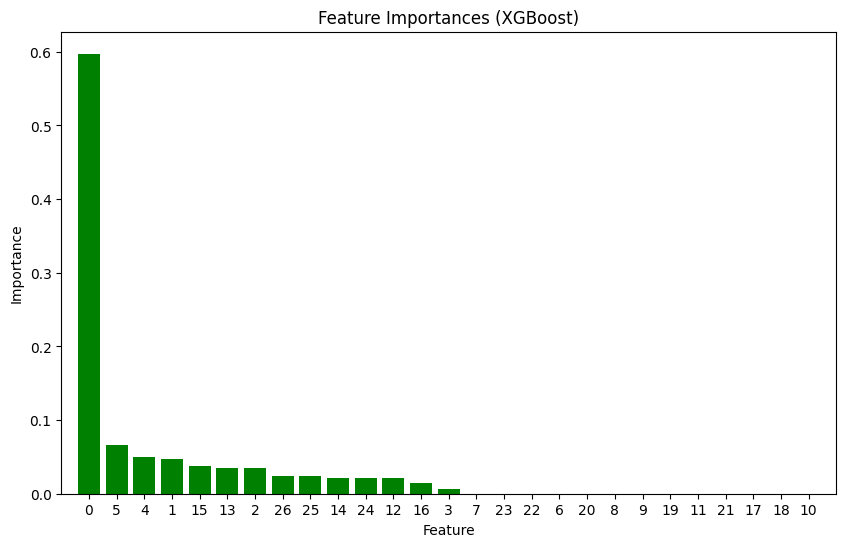

In [11]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Train the XGBoost classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

# Retrieve feature importances
importances = xgb_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (XGBoost)")
plt.bar(range(X_train.shape[1]), importances[indices], color="g", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

Prediction in New DataSet 

In [12]:
import pickle

model_path = 'rf_classifier_model.pkl'  # Change the path if it's different
with open(model_path, 'rb') as model_file:
    trained_model = pickle.load(model_file)

In [13]:
import pickle

model_path = 'rf_classifier_model.pkl'  # Change the path if it's different
with open(model_path, 'rb') as model_file:
    trained_model = pickle.load(model_file)

In [14]:
# Assuming you have the coordinate (129, 167, 55)
test_coordinate = (120, 150, 70)
roi_size = 10  # Same as the one used during feature extraction

swi_img = nib.load('14_T4_MRI_SWI_BFC_50mm_HM_sCMB_V1.nii.gz')  # Provide the correct path
swi_data = swi_img.get_fdata()

# Extract the ROI around the given coordinate
test_roi = extract_roi(swi_data, [test_coordinate], roi_size)[0]

# Compute Hessian matrix and eigenvalues for the ROI
eigenvalues_test_roi, _ = compute_hessian_eigenvalues(test_roi)

# Compute Radon features for the ROI
angles = np.arange(0, 180, 15)
radon_features_test_roi = compute_radon_features([test_roi], angles)
# Compute Radon shape features for the ROI
fmean_test_roi, fstd_test_roi = compute_radon_shape_features(radon_features_test_roi)
# Combine the features
flattened_radon_values_test_roi = np.concatenate((fmean_test_roi.flatten(), fstd_test_roi.flatten()))
combined_features_test_roi = np.concatenate((flattened_radon_values_test_roi, np.array(compute_hessian_shape_features(eigenvalues_test_roi))))

# Reshape the features to match the input format expected by the model
features_for_prediction = combined_features_test_roi.reshape(1, -1)

In [15]:
prediction = trained_model.predict(features_for_prediction)
print(f"Prediction for coordinate {test_coordinate}: {prediction}")

Prediction for coordinate (120, 150, 70): [1.]
